In [1]:
import json
import csv
from create_img_with_tag import ImageSynthesizer
import matplotlib.pyplot as plt
import numpy as np
import random
import os
import cv2
import copy
import itertools

In [45]:
def resize_images(input_dir, output_dir, width, height):
    
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif')
    images = [f for f in os.listdir(input_dir) if f.lower().endswith(image_extensions)]

    if not images:
        print("No images found in the directory.")
        return

    for img_name in images:
        img_path = os.path.join(input_dir, img_name)
        output_path = os.path.join(output_dir, img_name)

        # Read image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Skipping {img_name}: Unable to read file.")
            continue

        # Resize image
        resized_image = cv2.resize(image, (width, height), interpolation=cv2.INTER_NEAREST)

        cv2.imwrite(output_path, resized_image)
        print(f"Resized and saved: {output_path}")

input_folder = "TagCustom52h12"  
output_folder = "TagCustom52h12_resized" 
target_width = 70  
target_height = 70 

resize_images(input_folder, output_folder, target_width, target_height)


Resized and saved: TagCustom52h12_resized/tag52_12_01907.png
Resized and saved: TagCustom52h12_resized/tag52_12_00238.png
Resized and saved: TagCustom52h12_resized/tag52_12_01729.png
Resized and saved: TagCustom52h12_resized/tag52_12_01458.png
Resized and saved: TagCustom52h12_resized/tag52_12_01950.png
Resized and saved: TagCustom52h12_resized/tag52_12_00958.png
Resized and saved: TagCustom52h12_resized/tag52_12_01730.png
Resized and saved: TagCustom52h12_resized/tag52_12_01347.png
Resized and saved: TagCustom52h12_resized/tag52_12_00662.png
Resized and saved: TagCustom52h12_resized/tag52_12_01510.png
Resized and saved: TagCustom52h12_resized/tag52_12_01030.png
Resized and saved: TagCustom52h12_resized/tag52_12_00366.png
Resized and saved: TagCustom52h12_resized/tag52_12_01180.png
Resized and saved: TagCustom52h12_resized/tag52_12_01104.png
Resized and saved: TagCustom52h12_resized/tag52_12_01776.png
Resized and saved: TagCustom52h12_resized/tag52_12_00931.png
Resized and saved: TagCu

In [ ]:
def create_edge_mask(marker_img):
    if len(marker_img.shape) == 3:
        marker_gray = cv2.cvtColor(marker_img, cv2.COLOR_BGR2GRAY)
    else:
        marker_gray = marker_img

    edges = cv2.Canny(marker_gray, 100, 200)
    edge_mask = np.zeros_like(marker_gray)
    edge_mask[edges > 0] = 255

    h, w = marker_gray.shape[:2]

    return edge_mask

def warp_edges_to_image(label, image):
    warped_edges_batch = np.zeros_like(image)
    for item in label:
        marker_id = item['tag_id']
        marker_path = f'TagCustom52h12_resized/tag52_12_{marker_id:05d}.png'
        marker = cv2.imread(marker_path, cv2.IMREAD_GRAYSCALE)
        corners = np.array(item['corners_outer'])
        h, w = image.shape[:2]
        marker_h, marker_w = marker.shape[:2]
        src_points = np.array([
            [0, 0],  # Top-left
            [marker_w - 1, 0],  # Top-right
            [marker_w - 1, marker_h - 1],  # Bottom-right
            [0, marker_h - 1]  # Bottom-left
        ], dtype=np.float32)

        H, _ = cv2.findHomography(src_points, corners)

        warped_marker = cv2.warpPerspective(marker, H, (w, h)) 
        edge_mask = create_edge_mask(warped_marker)

        warped_edges_batch[edge_mask > 0] = 255

    return warped_edges_batch

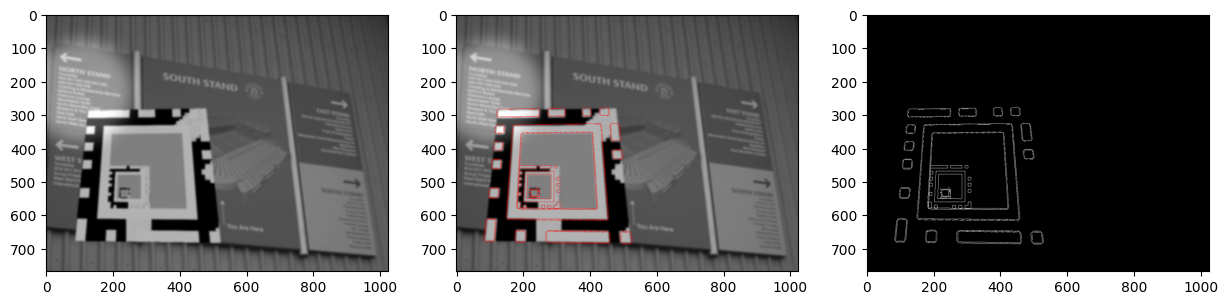

In [ ]:
file_path = '../dataset/inpaint/labels/test/0aa394880e667d5f.json'
im_path   = '../dataset/inpaint/images/test/0aa394880e667d5f.jpg'
image = cv2.imread(im_path, cv2.IMREAD_GRAYSCALE)

with open(file_path, 'r') as file:
    label = json.load(file)

warped_edges = warp_edges_to_image(label, image)

image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
red_edges = np.zeros_like(image_bgr)
red_edges[:, :, 2] = warped_edges  # Assign edges to red channel
overlayed = image_bgr
overlayed[warped_edges > 0] = [255, 0, 0]
# overlayed = cv2.addWeighted(image_bgr, 1, red_edges, 1, 0)

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(overlayed)
plt.subplot(1, 3, 3)
plt.imshow(warped_edges, cmap='gray')

In [65]:
def gen_custom_mask(image_dir, label_dir, mask_dir):

	if not os.path.exists(mask_dir):
		os.makedirs(mask_dir)
	
	for filename in os.listdir(image_dir):		
		if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')):
			img_file_path = os.path.join(image_dir, filename)
			mask_file_path = os.path.join(mask_dir, filename)
			label_file = os.path.splitext(filename)[0] + '.json'
			label_file_path = os.path.join(label_dir, label_file)
			with open(label_file_path, 'r') as file:
				label = json.load(file)
			warped_edges = warp_edges_to_image(label, image)

			cv2.imwrite(mask_file_path, warped_edges)
			print(f"Created {filename}.")

# Define your source and destination directories
image_directory        = '../dataset/inpaint/origs/test'
label_directory       = '../dataset/inpaint/labels/test'
mask_directory  = '../dataset/inpaint/custom_masks/test'

gen_custom_mask(image_directory, label_directory, mask_directory)


[{'image_size': [768, 1024], 'corners_outer': [[[820.7412109375, 464.1312255859375], [436.4450988769531, 409.910888671875], [434.6671142578125, 11.802658081054688], [899.8182373046875, 14.410598754882812]]], 'corners_inner': [[767.658935546875, 401.939453125], [813.7064819335938, 87.90908813476562], [486.7178649902344, 367.0018310546875], [491.9586181640625, 78.92601013183594]], 'bbox_corners': [[434.6671142578125, 11.802658081054688], [434.6671142578125, 464.1312255859375], [899.8182373046875, 464.1312255859375], [899.8182373046875, 11.802658081054688]], 'tag_id': 35, 'reflection_area': 0.0}, {'image_size': [768, 1024], 'corners_outer': [[[740.8678588867188, 370.55072021484375], [644.9953002929688, 359.45758056640625], [653.150634765625, 267.7803039550781], [753.340087890625, 276.4317626953125]]], 'corners_inner': [[728.4459228515625, 355.9970397949219], [736.8897094726562, 289.037841796875], [659.5490112304688, 348.304931640625], [665.7915649414062, 282.5905456542969]], 'bbox_corners